# QUELLE RÉPARTITION DES PRÊTS À LA MÉDIATHÈQUE ?

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import kiblib.utils.lucas_sns_params
from kiblib.utils.db import DbConn

In [2]:
maj = dt.today().strftime('%d-%m-%Y à %Hh%M' )
print(f"Dernière mise à jour le {maj}")

Dernière mise à jour le 17-01-2025 à 12h03


In [3]:
db_conn = DbConn().create_engine()

In [4]:
query = """SELECT issuedate, branchcode,location,categorycode,ccode,cardnumber 
FROM statdb.stat_issues si 
WHERE YEAR(issuedate) >= 2023"""

In [5]:
prets = pd.read_sql(query,db_conn)

In [6]:
query = """SELECT category,authorised_value AS 'ccode',lib_opac AS 'nom_collection'
FROM koha_prod.authorised_values av 
WHERE category = 'collection'"""

In [7]:
bloc_collections = pd.read_sql(query,db_conn)

In [8]:
prets = prets.merge(bloc_collections,left_on="ccode",right_on="ccode",how="left")

In [9]:
# Remplissage des noms de collection vides
prets["ccode"] = prets["ccode"].fillna("Pas d'infos")

# Ajout d'une colonne année
prets['annee'] = prets['issuedate'].dt.year

# Ajout d'une colonne mois

prets['mois'] = prets['issuedate'].dt.month_name(locale='fr_FR.utf8')

prets['month_number'] = prets['issuedate'].dt.strftime("%m")

# Ajout d'une valeur nombre de prêt
prets['nombre_prets'] = 1

In [10]:
prets = pd.DataFrame(prets,columns=["issuedate",
                                    "branchcode",
                                    "location",
                                    "categorycode",
                                    "cardnumber",
                                    "nombre_prets",
                                    "ccode",
                                    "nom_collection",
                                    "month_number",
                                    "mois",
                                    "annee"
                                   ])

In [11]:
prets_thisyear = prets[prets['annee']==dt.today().year]
#prets_thisyear = prets[prets['annee']==2024]

In [12]:
# EXCLU LA LOCALISATION COLLECTIVITÉS
#prets_thisyear_med = prets_thisyear[(prets_thisyear['location'].fillna('aucune donnée').str.contains('^MED')&
#                                    (prets_thisyear['location']!='MED0A'))]

In [13]:
# INCLUS LA LOCALISATION COLLECTIVITÉS
prets_thisyear_med = prets_thisyear[prets_thisyear['location'].fillna('aucune donnée').str.contains('^MED')]

In [14]:
total_prets_thisyear_med = len(prets_thisyear_med)

In [15]:
def repartition_by_espace(df):
    dico_etage = {'MED0C':'Rez-de-chaussée',
              'MED1A':'Lac',
              'MED2A':'Jeunesse',
              'MED3A':'Phare',
                  'MED0A':'Collectivités'
             }
    
    liste_etage = ['MED0C','MED1A','MED2A','MED3A','MED0A']
    resultat = pd.pivot_table(data=df[df['location'].isin(liste_etage)],
    #resultat = pd.pivot_table(data=df,
                              index=['location'],
                              values='nombre_prets',
                              aggfunc=sum,
                              sort=True
                             )
    resultat['part_prets_med_en_%'] = round((resultat['nombre_prets']/total_prets_thisyear_med)*100,1)
    resultat = resultat.rename(dico_etage,axis=0)
    resultat.index.names = ['Localisation']
    return(resultat)

In [16]:
def prets_by_month(df,location):
    resultat = pd.pivot_table(df[df['location']==location],
                              index=['month_number','mois'],
                              values='nombre_prets',
                              aggfunc=sum,
                              sort=True
                             )
    resultat['part_prets_med_en_%'] = round((resultat['nombre_prets']/total_prets_thisyear_med)*100,2)
    resultat = resultat.sort_values(by='month_number',ascending=True)
    resultat = resultat.droplevel(0)
    
    return(resultat)

In [17]:
def prets_by_collection(df,location):
    resultat = pd.pivot_table(df[df['location']==location],
                              index='nom_collection',
                              values='nombre_prets',
                              aggfunc=sum,
                              sort=True
                             )    
    resultat['part_prets_med_en_%'] = round((resultat['nombre_prets']/total_prets_thisyear_med)*100,2)
    resultat['part_prets_espace_en_%'] = round((resultat['nombre_prets']/resultat['nombre_prets'].sum())*100,1)
    resultat = resultat.sort_values(by='nombre_prets',ascending=False)
    
    return(resultat)

In [18]:
# Nombre de prêts par espace
prets_thisyear_by_espace = repartition_by_espace(df=prets_thisyear_med)

In [19]:
# Nombre de prêts par mois
prets_thisyear_bymonth_rdc = prets_by_month(df=prets_thisyear_med,location="MED0C")
prets_thisyear_bymonth_lac = prets_by_month(df=prets_thisyear_med,location="MED1A")
prets_thisyear_bymonth_jeunesse = prets_by_month(df=prets_thisyear_med,location="MED2A")
prets_thisyear_bymonth_phare = prets_by_month(df=prets_thisyear_med,location="MED3A")
###
prets_thisyear_bymonth_collectivites = prets_by_month(df=prets_thisyear_med,location="MED0A")

In [20]:
# Nombre de prêts par collections
prets_thisyear_rdc = prets_by_collection(df=prets_thisyear_med,location="MED0C")
prets_thisyear_lac = prets_by_collection(df=prets_thisyear_med,location="MED1A")
prets_thisyear_jeunesse = prets_by_collection(df=prets_thisyear_med,location="MED2A")
prets_thisyear_phare = prets_by_collection(df=prets_thisyear_med,location="MED3A")
###
prets_thisyear_collectivites = prets_by_collection(df=prets_thisyear_med,location="MED0A")

In [21]:
couleurs_par_espace = {'Rez-de-chaussée':'steelblue',
                       'Lac':'orange',
                       'Jeunesse':'fuchsia',
                       'Phare':'yellowgreen',
                       'Collectivités':'black'
                      }

# Répartition des prêts espace

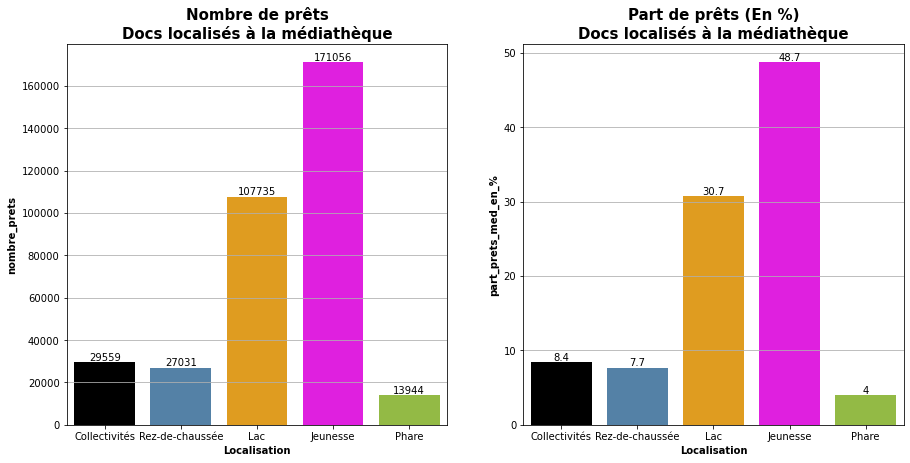

In [22]:
f,ax = plt.subplots(ncols=2,nrows=1,figsize=(15,7))


sns.barplot(data=prets_thisyear_by_espace,
            x=prets_thisyear_by_espace.index,
            y='nombre_prets',
            ax=ax[0],
            palette=couleurs_par_espace
           )
ax[0].set_title("Nombre de prêts\nDocs localisés à la médiathèque")

for i in ax[0].containers:
    ax[0].bar_label(i,)


sns.barplot(data=prets_thisyear_by_espace,
            x=prets_thisyear_by_espace.index,
            y='part_prets_med_en_%',
            palette=couleurs_par_espace,
            ax=ax[1]
           )
ax[1].set_title("Part de prêts (En %)\nDocs localisés à la médiathèque")


for i in ax[1].containers:
    ax[1].bar_label(i,)

# Évolution des prêts par espace

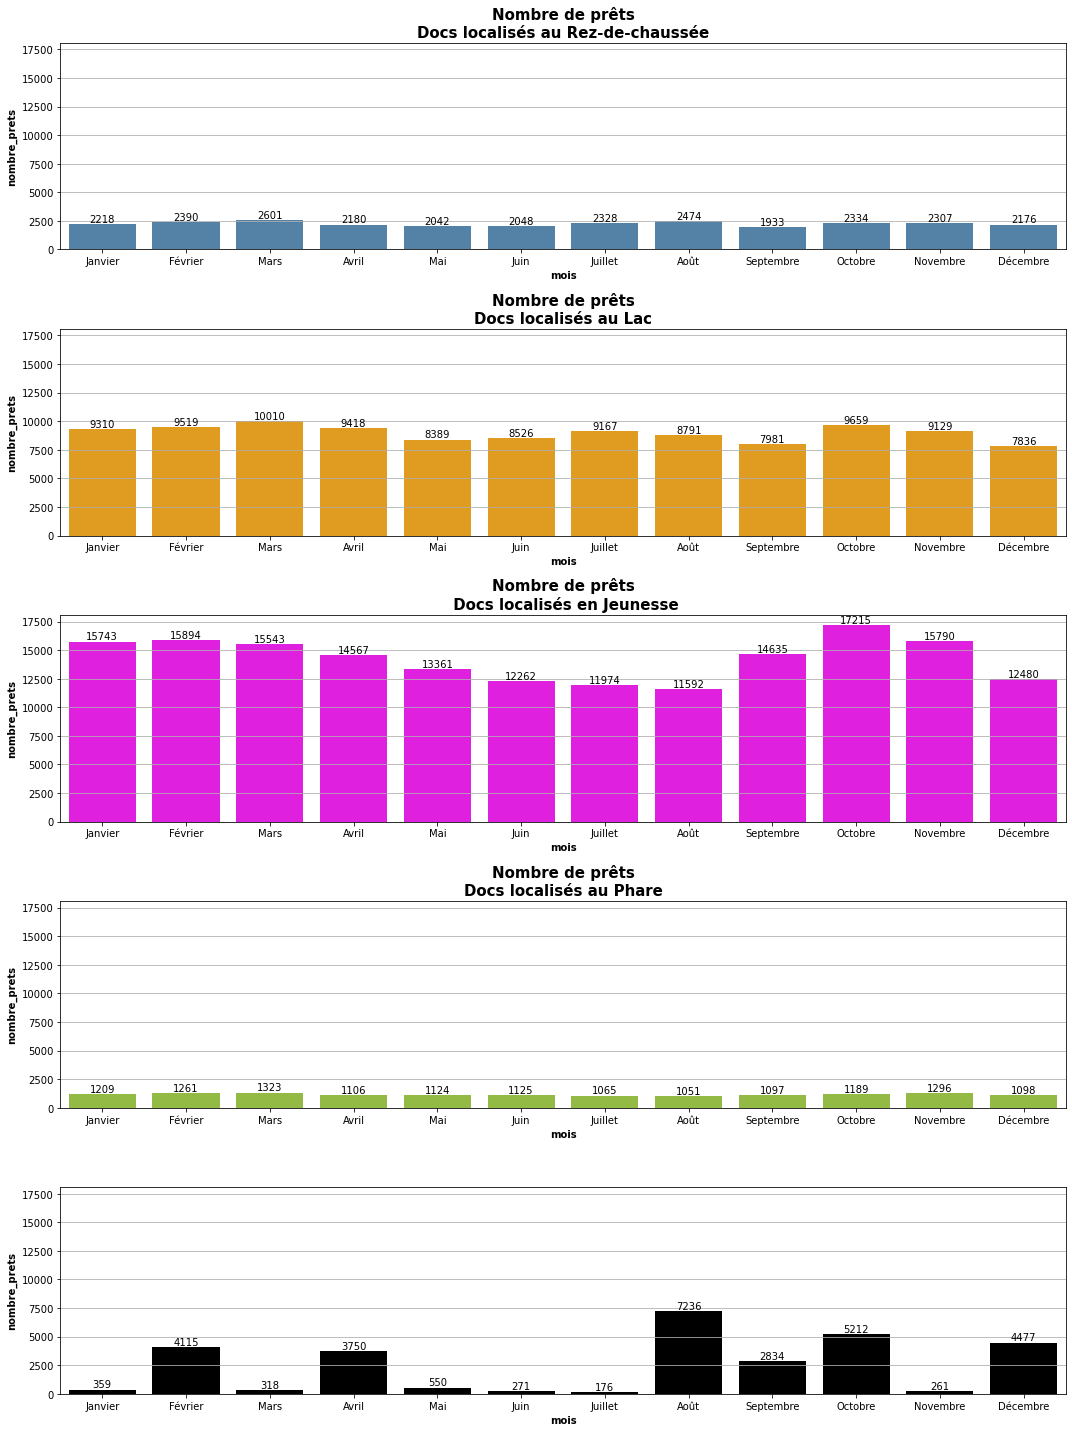

In [23]:
f,ax = plt.subplots(ncols=1,nrows=5,
                    figsize=(15,20),
                    sharey=True
                   )

# Rez-de-chaussée
sns.barplot(data=prets_thisyear_bymonth_rdc,
                x=prets_thisyear_bymonth_rdc.index,
                y="nombre_prets",ax=ax[0],
            color="steelblue",               )

ax[0].set_title("Nombre de prêts\nDocs localisés au Rez-de-chaussée")

for i in ax[0].containers:
    ax[0].bar_label(i,)
    
# Lac
sns.barplot(data=prets_thisyear_bymonth_lac,
                x=prets_thisyear_bymonth_lac.index,
                y="nombre_prets",ax=ax[1],
            color='orange'
               )

for i in ax[1].containers:
    ax[1].bar_label(i,)
    

ax[1].set_title("Nombre de prêts\nDocs localisés au Lac")
        
# Jeunesse
sns.barplot(data=prets_thisyear_bymonth_jeunesse,
                x=prets_thisyear_bymonth_jeunesse.index,
                y="nombre_prets",ax=ax[2],
            color='fuchsia',
             )
ax[2].set_title("Nombre de prêts\n Docs localisés en Jeunesse")


for i in ax[2].containers:
    ax[2].bar_label(i,)
        
    
# Phare
sns.barplot(data=prets_thisyear_bymonth_phare,
                x=prets_thisyear_bymonth_phare.index,
                y="nombre_prets",ax=ax[3],
            color='yellowgreen'
               )
ax[3].set_title("Nombre de prêts\nDocs localisés au Phare")


for i in ax[3].containers:
    ax[3].bar_label(i,)
    

# Collectivités
sns.barplot(data=prets_thisyear_bymonth_collectivites,
                x=prets_thisyear_bymonth_phare.index,
                y="nombre_prets",ax=ax[4],
            color='black'
               )
ax[3].set_title("Nombre de prêts\nDocs localisés au Phare")


for i in ax[4].containers:
    ax[4].bar_label(i,)
    
f.tight_layout()

# Nombre de prêts par espaces

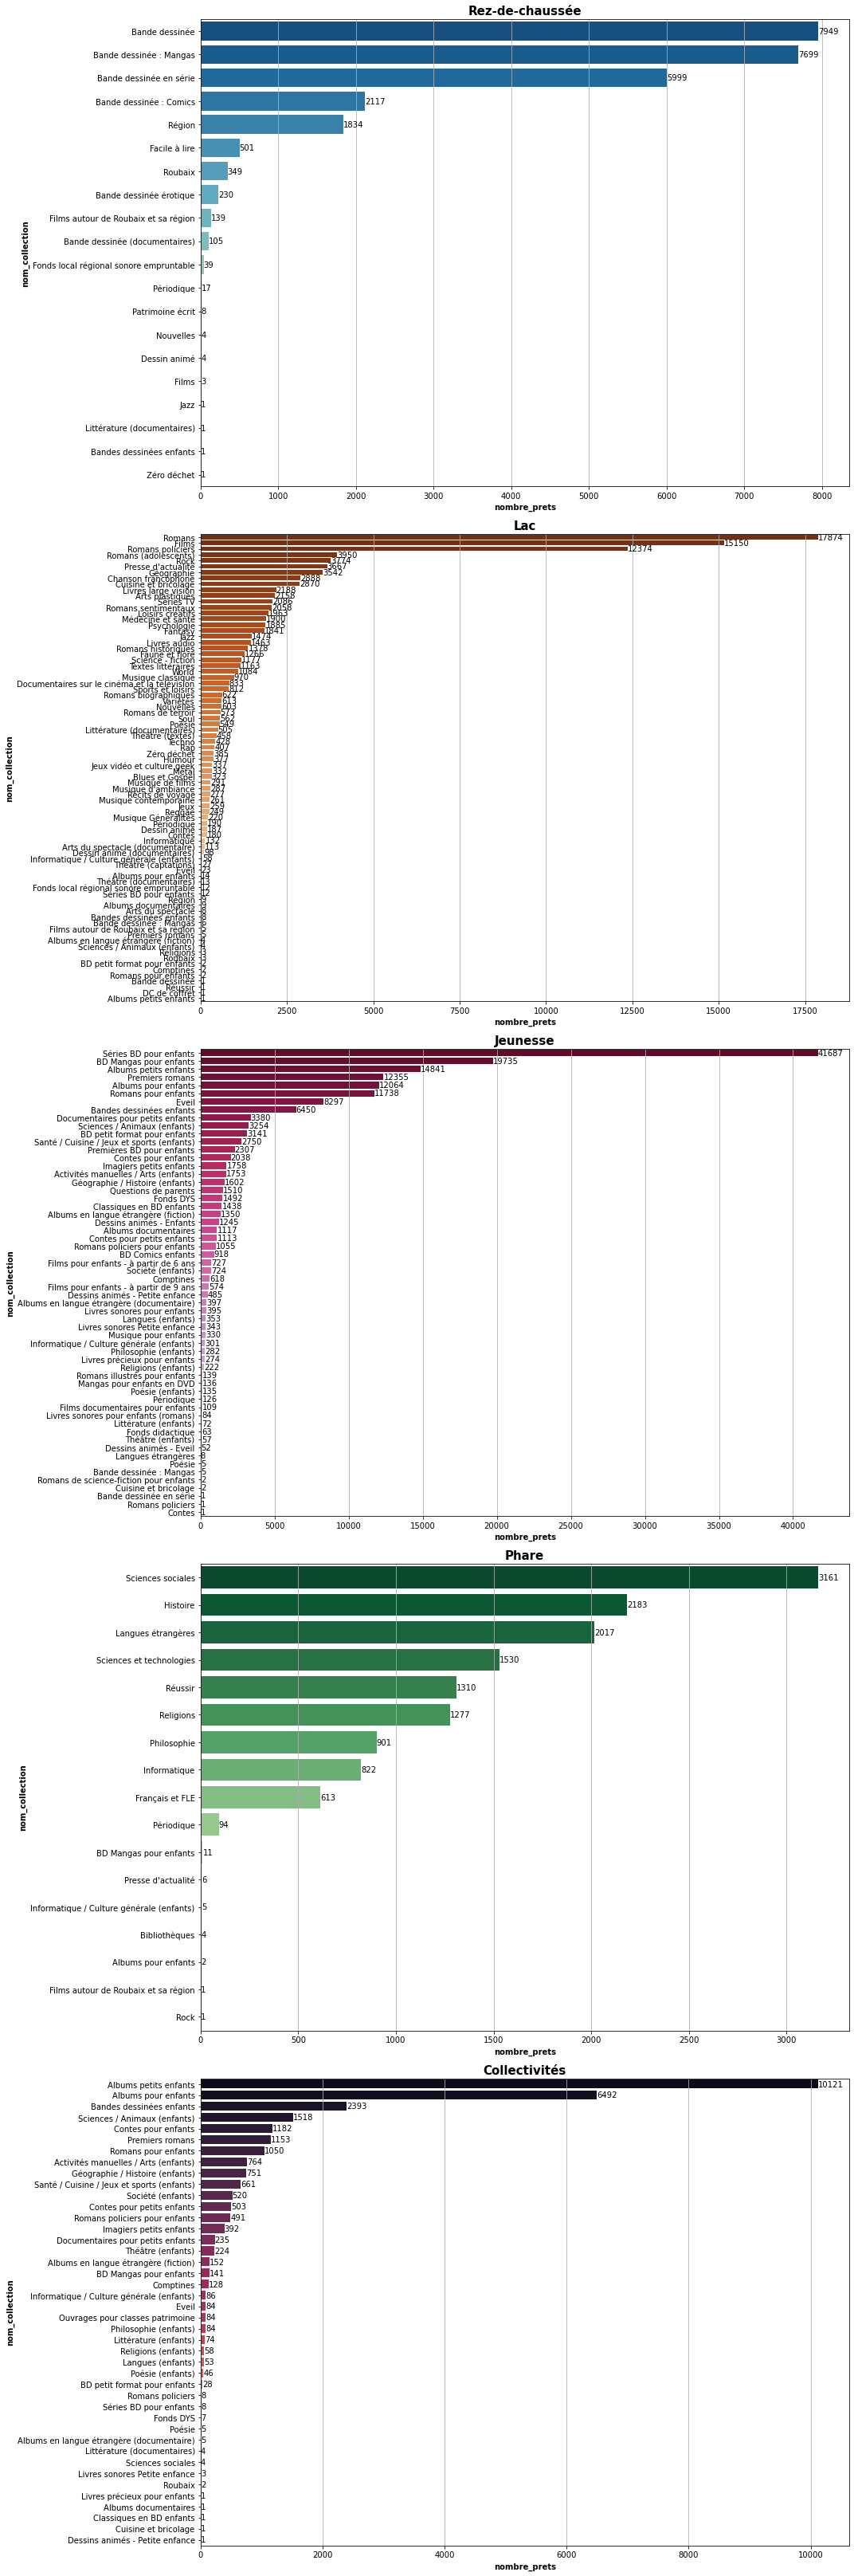

In [24]:
f,ax = plt.subplots(ncols=1,nrows=5,figsize=(15,45))

# Rez-de-chaussée
sns.barplot(data=prets_thisyear_rdc,
                y=prets_thisyear_rdc.index,
                x="nombre_prets",
            palette='GnBu_r',
            ax=ax[0])
ax[0].set_title("Rez-de-chaussée")

for i in ax[0].containers:
    ax[0].bar_label(i,)
    
# Lac
sns.barplot(data=prets_thisyear_lac,
                y=prets_thisyear_lac.index,
                x="nombre_prets",
            palette='Oranges_r',
            ax=ax[1])
ax[1].set_title("Lac")


for i in ax[1].containers:
    ax[1].bar_label(i,)
        
# Jeunesse
sns.barplot(data=prets_thisyear_jeunesse,
                y=prets_thisyear_jeunesse.index,
                x="nombre_prets",
            palette='PuRd_r',
            ax=ax[2])
ax[2].set_title("Jeunesse")

for i in ax[2].containers:
    ax[2].bar_label(i,)
        
    
# Phare
sns.barplot(data=prets_thisyear_phare,
                y=prets_thisyear_phare.index,
                x="nombre_prets",ax=ax[3],
            palette='YlGn_r')
ax[3].set_title("Phare")


for i in ax[3].containers:
    ax[3].bar_label(i,)
    

# Collectivités
sns.barplot(data=prets_thisyear_collectivites,
                y=prets_thisyear_collectivites.index,
                x="nombre_prets",ax=ax[4],
            palette='rocket')
ax[4].set_title("Collectivités")


for i in ax[4].containers:
    ax[4].bar_label(i,)
    
f.tight_layout()

# Répartition des prêts (En %) par espaces

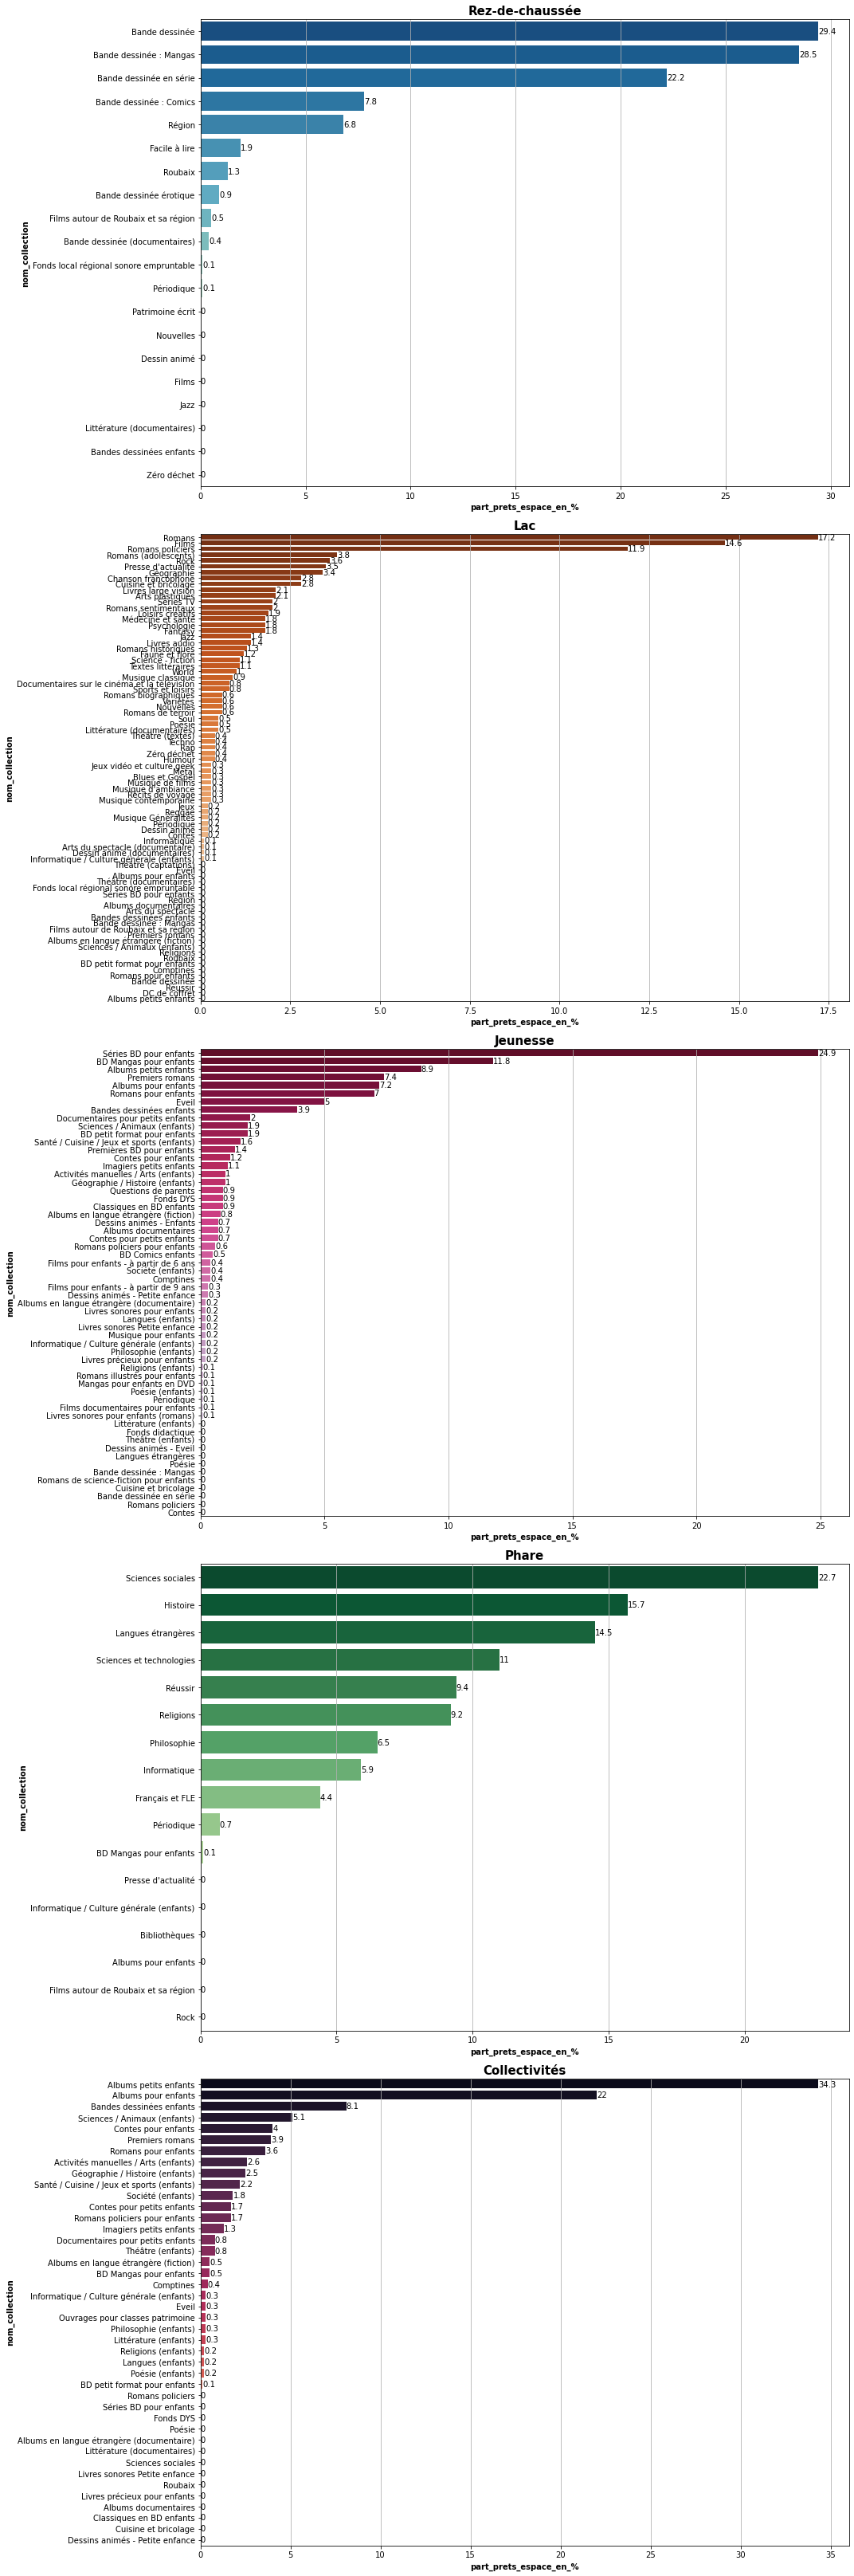

In [25]:
f,ax = plt.subplots(ncols=1,nrows=5,figsize=(15,45))

# Rez-de-chaussée
sns.barplot(data=prets_thisyear_rdc,
                y=prets_thisyear_rdc.index,
                x="part_prets_espace_en_%",
            palette='GnBu_r',
            ax=ax[0])
ax[0].set_title("Rez-de-chaussée")

for i in ax[0].containers:
    ax[0].bar_label(i,)
    
# Lac
sns.barplot(data=prets_thisyear_lac,
                y=prets_thisyear_lac.index,
                x="part_prets_espace_en_%",
            palette='Oranges_r',
            ax=ax[1])
ax[1].set_title("Lac")


for i in ax[1].containers:
    ax[1].bar_label(i,)
        
# Jeunesse
sns.barplot(data=prets_thisyear_jeunesse,
                y=prets_thisyear_jeunesse.index,
                x="part_prets_espace_en_%",
            palette='PuRd_r',
            ax=ax[2])
ax[2].set_title("Jeunesse")

for i in ax[2].containers:
    ax[2].bar_label(i,)
        
    
# Phare
sns.barplot(data=prets_thisyear_phare,
                y=prets_thisyear_phare.index,
                x="part_prets_espace_en_%",ax=ax[3],
            palette='YlGn_r')
ax[3].set_title("Phare")


for i in ax[3].containers:
    ax[3].bar_label(i,)
    
# Collectivités
sns.barplot(data=prets_thisyear_collectivites,
                y=prets_thisyear_collectivites.index,
                x="part_prets_espace_en_%",ax=ax[4],
            palette='rocket')
ax[4].set_title("Collectivités")
for i in ax[4].containers:
    ax[4].bar_label(i)
    
f.tight_layout()

# Répartition des prêts (en %) sur le total de prêts médiathèque

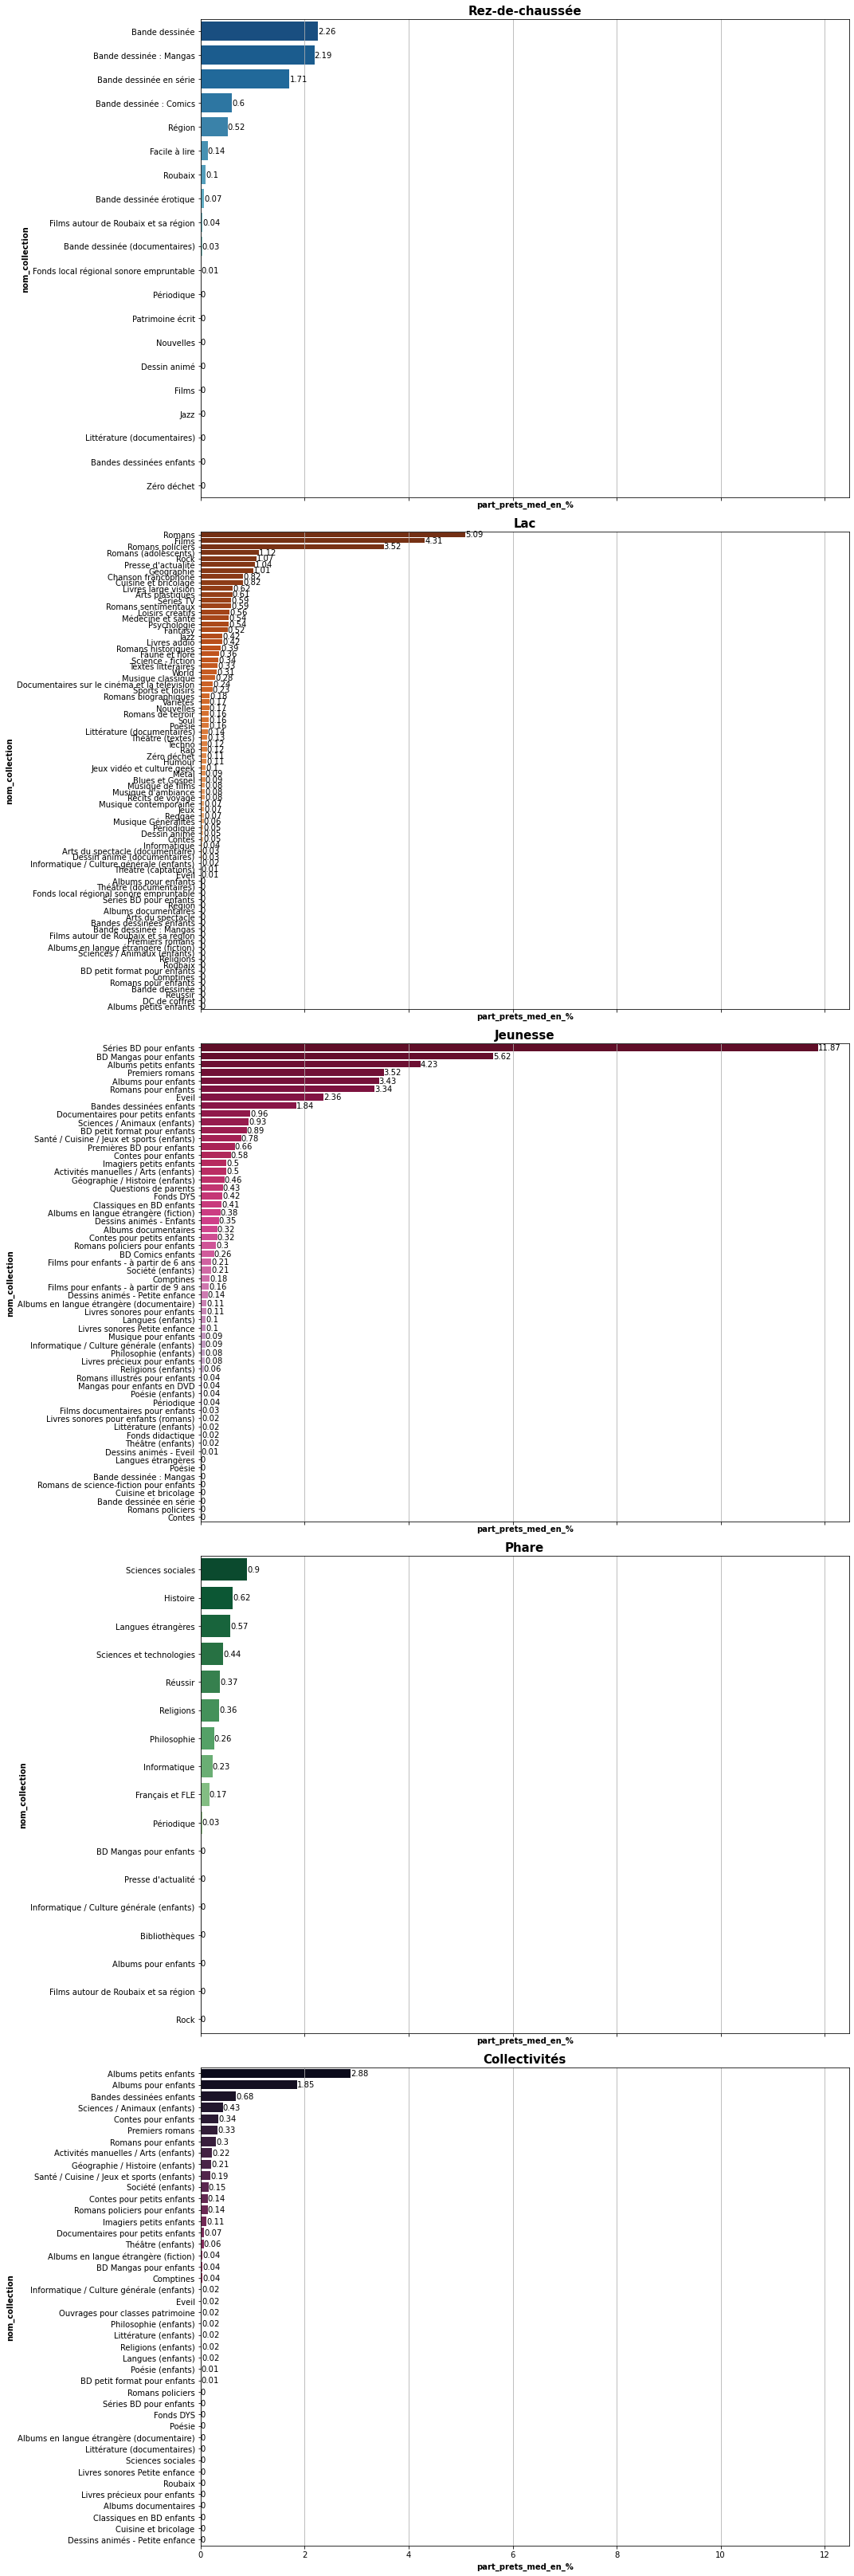

In [26]:
f,ax = plt.subplots(ncols=1,nrows=5,figsize=(15,45),sharex=True)

# Rez-de-chaussée
sns.barplot(data=prets_thisyear_rdc,
                y=prets_thisyear_rdc.index,
                x="part_prets_med_en_%",
            palette='GnBu_r',
            ax=ax[0])
ax[0].set_title("Rez-de-chaussée")

for i in ax[0].containers:
    ax[0].bar_label(i,)
    
# Lac
sns.barplot(data=prets_thisyear_lac,
                y=prets_thisyear_lac.index,
                x="part_prets_med_en_%",
            palette='Oranges_r',
            ax=ax[1])
ax[1].set_title("Lac")


for i in ax[1].containers:
    ax[1].bar_label(i,)
        
# Jeunesse
sns.barplot(data=prets_thisyear_jeunesse,
                y=prets_thisyear_jeunesse.index,
                x="part_prets_med_en_%",
            palette='PuRd_r',
            ax=ax[2])
ax[2].set_title("Jeunesse")

for i in ax[2].containers:
    ax[2].bar_label(i,)
        
    
# Phare
sns.barplot(data=prets_thisyear_phare,
                y=prets_thisyear_phare.index,
                x="part_prets_med_en_%",ax=ax[3],
            palette='YlGn_r')
ax[3].set_title("Phare")


for i in ax[3].containers:
    ax[3].bar_label(i,)
    
# Collectivités
sns.barplot(data=prets_thisyear_collectivites,
                y=prets_thisyear_collectivites.index,
                x="part_prets_med_en_%",ax=ax[4],
            palette='rocket')
ax[4].set_title("Collectivités")
for i in ax[4].containers:
    ax[4].bar_label(i)
    
f.tight_layout()